In [1]:
import os
import numpy as np
import pandas as pd
import torch
import cv2
from PIL import Image

In [2]:
# GPU 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## 파일 읽어오기

In [3]:
pathes = []

for dirpath, dirnames, filenames in os.walk('data/demo'):
    for filename in filenames:
        file_path = dirpath + '/' + filename
        pathes.append(file_path)
        
data_df = pd.DataFrame(pathes, columns=['path'])
data_df

path
0    data/demo/150년 수령 느티나무.png
1      data/demo/3.1독립선언기념탑.png
2      data/demo/3.1독립운동기념탑.png
3           data/demo/63스퀘어.png
4           data/demo/AHC스파.png
..                          ...
464    data/demo/효민공 이경직 묘역.png
465           data/demo/효사정.png
466         data/demo/훈련원공원.png
467          data/demo/흥인지문.png
468           data/demo/흥천사.png

[469 rows x 1 columns]

## 데이터셋 생성

In [4]:
from torch.utils.data import Dataset
import torchvision.transforms as T


transforms = T.Compose([T.ToTensor(),
                       T.Resize((256,256))])
main_dir = 'data/demo'


class TouristSpotDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")


        if self.transform is not None:
            image = self.transform(image)

        return image, image

In [5]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

full_dataset = TouristSpotDataset(main_dir, transforms)
train_dataset, val_dataset = random_split(full_dataset, [int(len(full_dataset)*0.8), int(len(full_dataset)*0.2)+1]) 

full_loader = DataLoader(full_dataset, batch_size=16)
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

## 모델 정의

Output Size = (W - F + 2P) / S + 1
- w : 인풋
- f ; 커널사이즈
- p : 패딩
- s : stride

In [6]:
from torch import nn 
from torch.nn import Conv2d, ReLU, MaxPool2d, ConvTranspose2d



class ConvEncoder(nn.Module):
    """
    A simple Convolutional Encoder Model
    """

    def __init__(self):
        super().__init__()
        # 256 x 256 x 3  -->  128 x 128 x 16
        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))
        
        # 128 x 128 x 16  -->  64 x 64 x 32
        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))
        
        # 64 x 64 x 32  -->  32 x 32 x 64
        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))
        
        # 32 x 32 x 64  -->  16 x 16 x 128
        self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d((2, 2))
        
        # 16 x 16 x 128  --> 8 x 8 x 256
        self.conv5 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d((2, 2))
        
    

    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        
        return x

In [7]:

class ConvDecoder(nn.Module):
    """
    A simple Convolutional Decoder Model
    """

    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(256, 128, (2, 2), stride=(2, 2))
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 2), stride=(2, 2))
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)

        self.deconv4 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
        self.relu4 = nn.ReLU(inplace=True)

        self.deconv5 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
        self.relu5 = nn.ReLU(inplace=True)

    def forward(self, x):
         # Upscale the image with convtranspose etc.
        x = self.deconv1(x)
        x = self.relu1(x)

        x = self.deconv2(x)
        x = self.relu2(x)

        x = self.deconv3(x)
        x = self.relu3(x)

        x = self.deconv4(x)
        x = self.relu4(x)

        x = self.deconv5(x)
        x = self.relu5(x)
        return x

In [10]:
from torch import optim


loss_fn = nn.MSELoss() # We use Mean squared loss which computes difference between two images.

encoder = ConvEncoder() # Our encoder model
decoder = ConvDecoder() # Our decoder model

# Shift models to GPU
encoder.to(device)
decoder.to(device)

# Both the enocder and decoder parameters
autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(autoencoder_params, lr=1e-3) # Adam Optimizer

# Time to Train !!!
EPOCHS = 10
# Usual Training Loop
for epoch in tqdm(range(EPOCHS)):
        train_loss = train_step(encoder, decoder, train_loader, loss_fn, optimizer, device=device)
        
        print(f"Epochs = {epoch}, Training Loss : {train_loss}")
        
        val_loss = val_step(encoder, decoder, val_loader, loss_fn, device=device)
        
        print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

        # Simple Best Model saving
#         if val_loss < max_loss:
#             print("Validation Loss decreased, saving new best model")
#             torch.save(encoder.state_dict(), "encoder_model.pt")
#             torch.save(decoder.state_dict(), "decoder_model.pt")

# Save the feature representations.
EMBEDDING_SHAPE = (1, 256, 8, 8) # This we know from our encoder

# We need feature representations for complete dataset not just train and validation.
# Hence we use full loader here.
embedding = create_embedding(encoder, full_loader, EMBEDDING_SHAPE, device)

# Convert embedding to numpy and save them
numpy_embedding = embedding.cpu().detach().numpy()
num_images = numpy_embedding.shape[0]

# Save the embeddings for complete dataset, not just train
flattened_embedding = numpy_embedding.reshape((num_images, -1))
np.save("data_embedding.npy", flattened_embedding)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\actye\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epochs = 0, Training Loss : 0.30422747135162354


 10%|█         | 1/10 [00:10<01:31, 10.17s/it]

Epochs = 0, Validation Loss : 0.3121689260005951
Epochs = 1, Training Loss : 0.30422747135162354


 20%|██        | 2/10 [00:16<01:12,  9.04s/it]

Epochs = 1, Validation Loss : 0.3121689260005951
Epochs = 2, Training Loss : 0.30422747135162354


 30%|███       | 3/10 [00:23<00:58,  8.30s/it]

Epochs = 2, Validation Loss : 0.3121689260005951
Epochs = 3, Training Loss : 0.30422747135162354


 40%|████      | 4/10 [00:29<00:45,  7.65s/it]

Epochs = 3, Validation Loss : 0.3121689260005951
Epochs = 4, Training Loss : 0.30422747135162354


 50%|█████     | 5/10 [00:36<00:37,  7.58s/it]

Epochs = 4, Validation Loss : 0.3121689260005951
Epochs = 5, Training Loss : 0.30422747135162354


 60%|██████    | 6/10 [00:46<00:33,  8.31s/it]

Epochs = 5, Validation Loss : 0.3121689260005951
Epochs = 6, Training Loss : 0.30422747135162354


 70%|███████   | 7/10 [00:56<00:26,  8.78s/it]

Epochs = 6, Validation Loss : 0.3121689260005951
Epochs = 7, Training Loss : 0.30422747135162354


 80%|████████  | 8/10 [01:04<00:17,  8.62s/it]

Epochs = 7, Validation Loss : 0.3121689260005951
Epochs = 8, Training Loss : 0.30422747135162354


 90%|█████████ | 9/10 [01:12<00:08,  8.41s/it]

Epochs = 8, Validation Loss : 0.3121689260005951
Epochs = 9, Training Loss : 0.30422747135162354


100%|██████████| 10/10 [01:19<00:00,  7.95s/it]

Epochs = 9, Validation Loss : 0.3121689260005951


In [8]:

def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):
    """
    Performs a single training step
    Args:
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    decoder: A convolutional Decoder. E.g. torch_model ConvDecoder
    train_loader: PyTorch dataloader, containing (images, images).
    loss_fn: PyTorch loss_fn, computes loss between 2 images.
    optimizer: PyTorch optimizer.
    device: "cuda" or "cpu"
    Returns: Train Loss
    """
    #  Set networks to train mode.
    encoder.train()
    decoder.train()

    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        # Move images to device
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        
        # Zero grad the optimizer
        optimizer.zero_grad()
        # Feed the train images to encoder
        enc_output = encoder(train_img)
        # The output of encoder is input to decoder !
        dec_output = decoder(enc_output)
        
        # Decoder output is reconstructed image
        # Compute loss with it and orginal image which is target image.
        loss = loss_fn(dec_output, target_img)
        # Backpropogate
        loss.backward()
        # Apply the optimizer to network by calling step.
        optimizer.step()
    # Return the loss
    return loss.item()

def val_step(encoder, decoder, val_loader, loss_fn, device):
    """
    Performs a single training step
    Args:
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    decoder: A convolutional Decoder. E.g. torch_model ConvDecoder
    val_loader: PyTorch dataloader, containing (images, images).
    loss_fn: PyTorch loss_fn, computes loss between 2 images.
    device: "cuda" or "cpu"
    Returns: Validation Loss
    """
    
    # Set to eval mode.
    encoder.eval()
    decoder.eval()
    
    # We don't need to compute gradients while validating.
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            # Move to device
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # Again as train. Feed encoder the train image.
            enc_output = encoder(train_img)
            # Decoder takes encoder output and reconstructs the image.
            dec_output = decoder(enc_output)

            # Validation loss for encoder and decoder.
            loss = loss_fn(dec_output, target_img)
    # Return the loss
    return loss.item()

In [9]:
def create_embedding(encoder, full_loader, embedding_dim, device):
    """
    Creates embedding using encoder from dataloader.
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    full_loader: PyTorch dataloader, containing (images, images) over entire dataset.
    embedding_dim: Tuple (c, h, w) Dimension of embedding = output of encoder dimesntions.
    device: "cuda" or "cpu"
    Returns: Embedding of size (num_images_in_loader + 1, c, h, w)
    """
    # Set encoder to eval mode.
    encoder.eval()
    # Just a place holder for our 0th image embedding.
    embedding = torch.randn(embedding_dim)
    
    # Again we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
            # We can compute this on GPU. be faster
            train_img = train_img.to(device)
            
            # Get encoder outputs and move outputs to cpu
            enc_output = encoder(train_img).cpu()
            # Keep adding these outputs to embeddings.
            embedding = torch.cat((embedding, enc_output), 0)
    # Return the embeddings
    return embedding 

## 코사인 유사도

In [11]:
data = np.load('data_embedding.npy')
data.shape

(470, 16384)

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(data, data)

In [13]:
def extract_recommend_idx(idx):
    
    sorted_idx = sim.argsort()[:,::-1]
    result = sorted_idx[idx,:5]
    return result

In [14]:
recommend_idx = extract_recommend_idx(80)

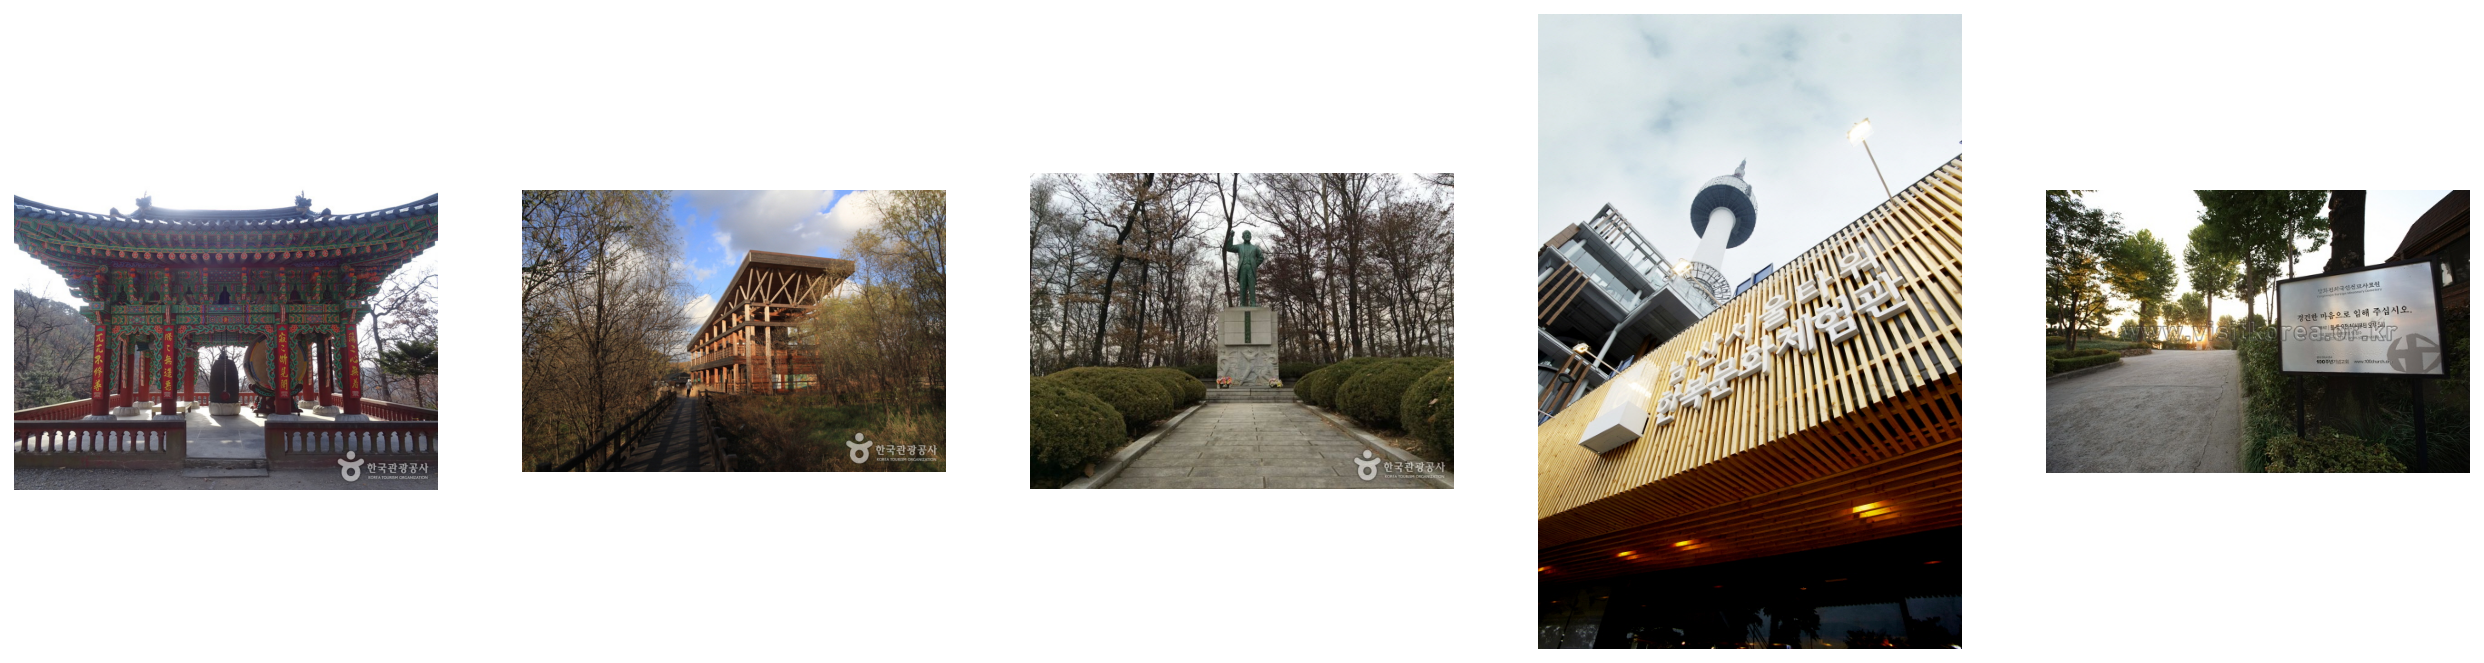

In [15]:
def show_result(recommend_idx):
    data_df.loc[recommend_idx,:]

    figure, axs = plt.subplots(ncols=5, figsize=(22,15))

    for idx, path in enumerate(data_df.loc[recommend_idx, 'path']):
        img_array = np.fromfile(path, np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[idx].imshow(img)
        axs[idx].axis('off')
        
show_result(recommend_idx)

In [16]:
from sklearn.neighbors import NearestNeighbors


def compute_similar_images(image, num_images, embedding, device):
    """
    Given an image and number of similar images to search.
    Returns the num_images closest neares images.
    Args:
    image: Image whose similar images are to be found.
    num_images: Number of similar images to find.
    embedding : A (num_images, embedding_dim) Embedding of images learnt from auto-encoder.
    device : "cuda" or "cpu" device.
    """
    transforms = T.Compose([T.ToTensor(),
                           T.Resize((256,256))])
    
    image_tensor = transforms(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.cuda()
    
    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()
        
    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))
    print(flattened_embedding.shape)
    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)

    _, indices = knn.kneighbors(flattened_embedding)
    indices_list = indices.tolist()
    return indices_list

(-0.5, 699.5, 466.5, -0.5)

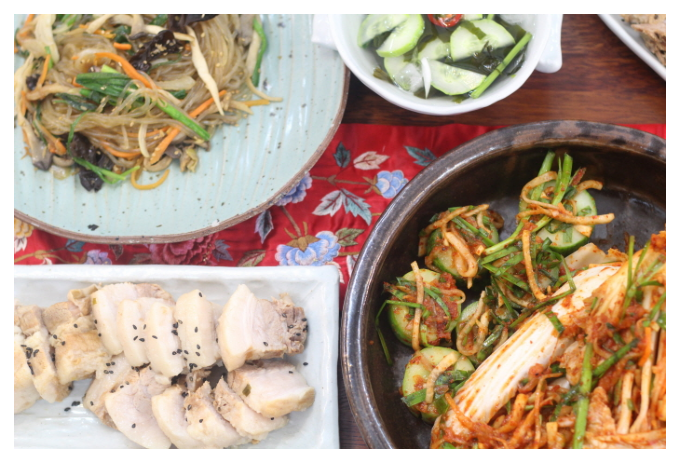

In [46]:
image_path = data_df['path'][320]
img_array = np.fromfile(image_path, np.uint8)
img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

In [32]:
recommend_idx = compute_similar_images(img, 5, data, device)[0]

(1, 16384)


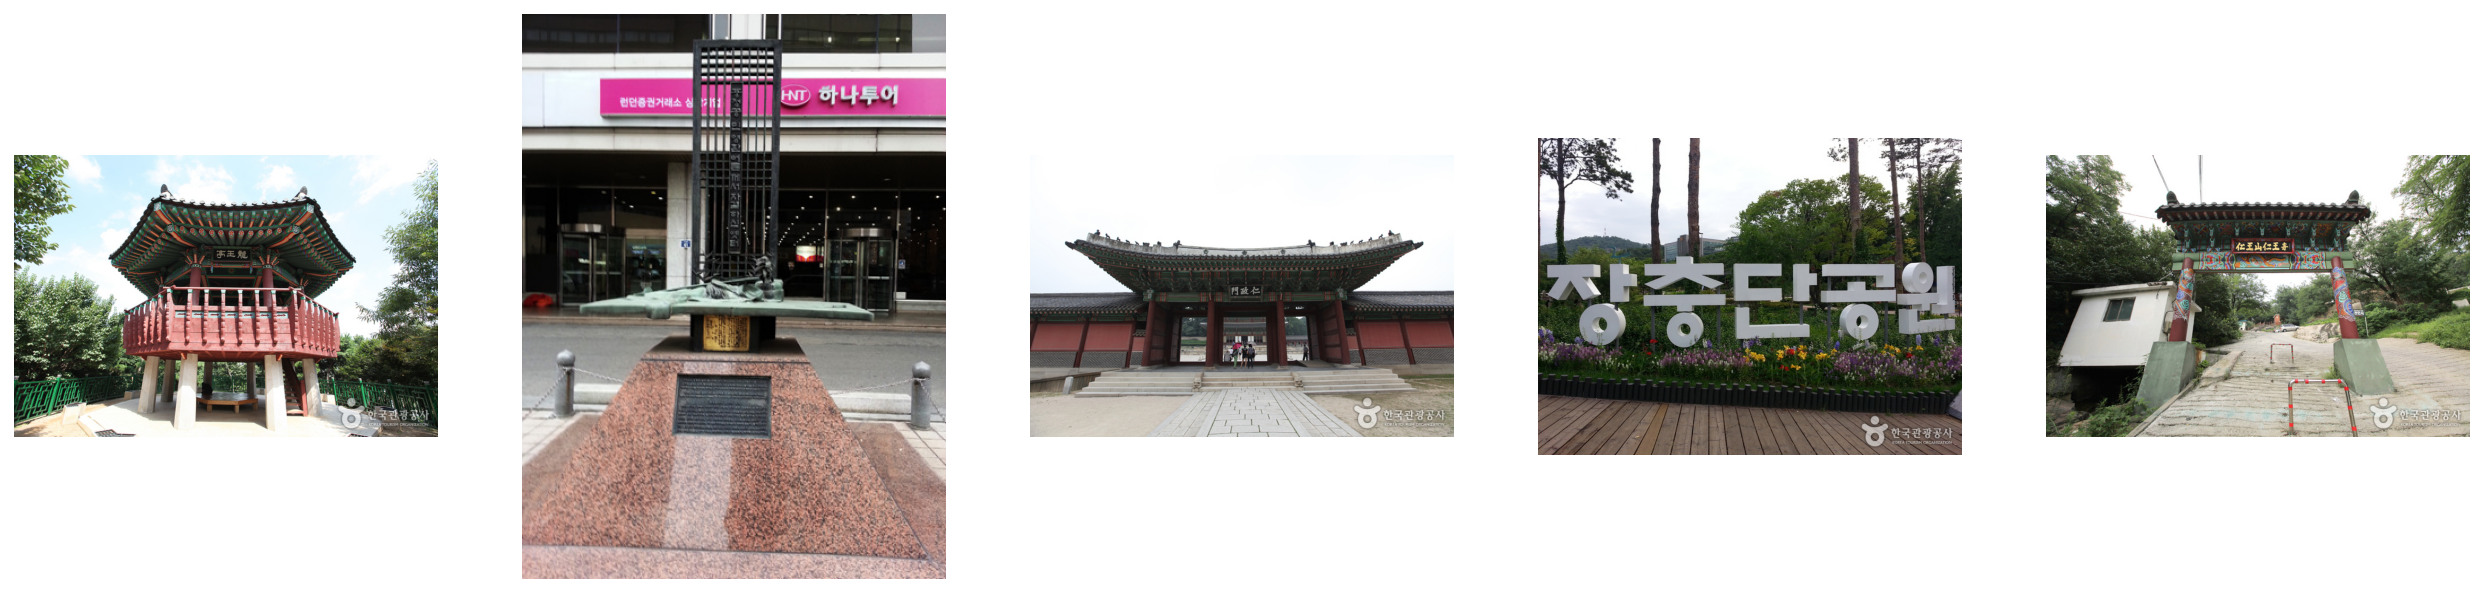

In [33]:
def show_result(recommend_idx):
    data_df.loc[recommend_idx,:]

    figure, axs = plt.subplots(ncols=5, figsize=(22,15))

    for idx, path in enumerate(data_df.loc[recommend_idx, 'path']):
        img_array = np.fromfile(path, np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[idx].imshow(img)
        axs[idx].axis('off')
        
show_result(recommend_idx)